In [16]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.nam import NAM
from models.dnn import DNN
from models.utils import *

from config.default import defaults

from trainer.trainer import Trainer
from trainer.raytrainer import *

from data.toydataset import ToyDataset
from data.generator import *

from typing import Sequence 
from typing import List

import matplotlib.pyplot as plt 
import numpy as np

import ray
from ray import tune, air
from ray.tune.schedulers import ASHAScheduler 
from ray.tune import CLIReporter


"""
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [17]:
%reload_ext autoreload 
%autoreload 2

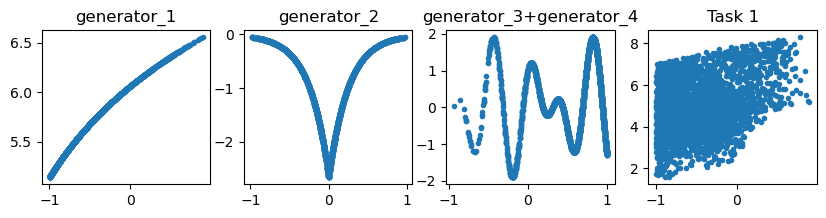

In [18]:
cfg = defaults()
gen_funcs, gen_func_names = task_1()

toydataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=False,
)
toydataset.plot()

# Ray Tune 

In [19]:
dropout_ss = [*np.arange(0, 1, 0.1)] + [0.05]
print(dropout_ss)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 0.05]


In [20]:
config = {
    "lr": tune.loguniform(1e-3, 1e-1),
    "decay_rate": tune.grid_search([*np.arange(0, 0.005, 0.001)])
}
"""
cfg.lr = tune.loguniform(1e-3, 1e-1) 

cfg.activation = tune.grid_search(['exu', 'relu'])

dropout_ss = [*np.arange(0, 1, 0.1)] + [0.05]
cfg.dropout = tune.grid_search(dropout_ss)
cfg.feature_dropout = tune.grid_search([*np.arange(0, 0.25, 0.05)])
cfg.l2_regularization=tune.loguniform(1e-6, 1e-4)
cfg.output_regularization=tune.loguniform(1e-3, 1e-1)
print(cfg)
"""

"\ncfg.lr = tune.loguniform(1e-3, 1e-1) \n\ncfg.activation = tune.grid_search(['exu', 'relu'])\n\ndropout_ss = [*np.arange(0, 1, 0.1)] + [0.05]\ncfg.dropout = tune.grid_search(dropout_ss)\ncfg.feature_dropout = tune.grid_search([*np.arange(0, 0.25, 0.05)])\ncfg.l2_regularization=tune.loguniform(1e-6, 1e-4)\ncfg.output_regularization=tune.loguniform(1e-3, 1e-1)\nprint(cfg)\n"

In [21]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=4)

metrics_name = "MAE" if cfg.regression else "Accuracy"
scheduler = ASHAScheduler(
        metric=metrics_name,
        mode="min",
    )

result = tune.run(
    partial(train, dataset=toydataset, static_cfg=cfg),
    config=config,
    num_samples=1,
    scheduler=scheduler)

(func pid=1135) epoch=1, loss_train: 2.726, metrics_train: 1.231 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(func pid=1135) epoch=1, loss_val: 1.555, metrics_val: 1.008 [repeated 4x across cluster]


2023-06-30 10:40:03,743	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,MAE,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_5a4bc_00000,0.277073,2023-06-30_10-41-16,True,"0_decay_rate=0.0000,lr=0.0118",pe8.int.triton.aalto.fi,10,0.255616,10.10.100.8,2344,10.6241,0.894815,10.6241,1688110876,10,5a4bc_00000
train_5a4bc_00001,0.366911,2023-06-30_10-41-16,True,"1_decay_rate=0.0010,lr=0.0478",pe8.int.triton.aalto.fi,10,0.294053,10.10.100.8,2345,10.8117,0.948648,10.8117,1688110876,10,5a4bc_00001
train_5a4bc_00002,0.986669,2023-06-30_10-41-07,True,,pe8.int.triton.aalto.fi,1,1.44997,10.10.100.8,2346,1.82413,1.82413,1.82413,1688110867,1,5a4bc_00002
train_5a4bc_00003,1.0285,2023-06-30_10-41-07,True,,pe8.int.triton.aalto.fi,1,1.54744,10.10.100.8,2347,1.80455,1.80455,1.80455,1688110867,1,5a4bc_00003
train_5a4bc_00004,0.701124,2023-06-30_10-41-16,True,"4_decay_rate=0.0040,lr=0.0032",pe8.int.triton.aalto.fi,10,0.798819,10.10.100.8,2348,10.6685,0.902335,10.6685,1688110876,10,5a4bc_00004


(func pid=2345) epoch=1, loss_train: 3.107, metrics_train: 1.270
(func pid=2345) epoch=1, loss_val: 1.260, metrics_val: 0.915
(func pid=2344) Finished Training.
(func pid=2347) epoch=1, loss_train: 2.428, metrics_train: 1.191 [repeated 4x across cluster]
(func pid=2347) epoch=1, loss_val: 1.547, metrics_val: 1.029 [repeated 4x across cluster]


2023-06-30 10:41:16,541	INFO tune.py:1111 -- Total run time: 61.39 seconds (61.35 seconds for the tuning loop).


In [22]:
best_trial = result.get_best_trial(metric=metrics_name, mode="min", scope="last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation metric: {best_trial.last_result[metrics_name]}")

Best trial config: {'lr': 0.011816619651884446, 'decay_rate': 0.0}
Best trial final validation loss: 0.25561636686325073
Best trial final validation metric: 0.2770727135241032


loss_train_epoch: 2.256197690963745, MAE_train_epoch: 1.1860161405621152
loss_val_epoch: 1.2884962558746338, MAE_val_epoch: 0.9243046343326569
loss_train_epoch: 0.06028960645198822, MAE_train_epoch: 0.17326635144876712
loss_val_epoch: 0.05030839890241623, MAE_val_epoch: 0.15231663286685942
loss_train_epoch: 0.07145794481039047, MAE_train_epoch: 0.19853819647070134
loss_val_epoch: 0.05911523103713989, MAE_val_epoch: 0.15657750591635705
loss_train_epoch: 0.04253510758280754, MAE_train_epoch: 0.13756669922308487
loss_val_epoch: 0.02920668199658394, MAE_val_epoch: 0.11659888699650764
loss_train_epoch: 0.031186003237962723, MAE_train_epoch: 0.11291520732144515
loss_val_epoch: 0.039179105311632156, MAE_val_epoch: 0.1391988806426525
The minimum validation loss: 0.01840568147599697
The minimum validation metrics: 0.063140326179564


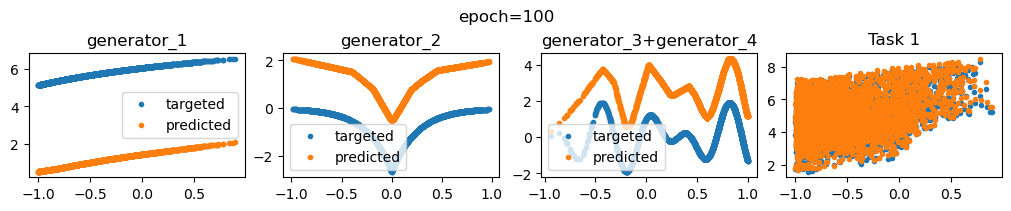

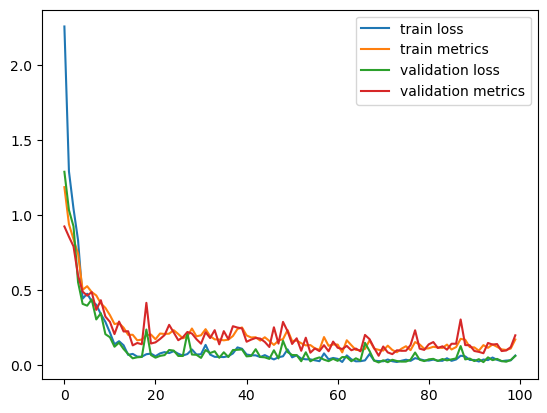

In [26]:
cfg.lr = 0.011816619651884446
cfg.decay_rate = 0
cfg.num_epochs = 100
best_trained_model = NAM(config=cfg, 
                         name="NAM_FINE_TUNE", 
                         in_features=len(toydataset[0][0]), 
                         num_units=cfg.num_basis_functions)


trainer = Trainer(cfg, best_trained_model, toydataset)   
losses_train, metricses_train, losses_val, metricses_val = trainer.train()

#best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
#best_checkpoint_data = best_checkpoint.to_dict()

#best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])


# Trainer Sample

In [6]:
nam_relu = NAM(
    config=cfg, 
    name="NAM Model", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(nam_relu)
trainer_relu = Trainer(cfg, nam_relu, toydataset)   

NAM(
  (feature_dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=64)
        (1): Dropout(p=0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0, inplace=False)
      )
    )
  )
)


loss_train_epoch: 3.2857863903045654, MAE_train_epoch: 1.3957105260906797
loss_val_epoch: 1.7234054803848267, MAE_val_epoch: 1.0781095981597901
loss_train_epoch: 1.0440930128097534, MAE_train_epoch: 0.8356424588145632
loss_val_epoch: 0.9061102867126465, MAE_val_epoch: 0.7770278751850128
The minimum validation loss: 0.39298564195632935
The minimum validation metrics: 0.462592813372612


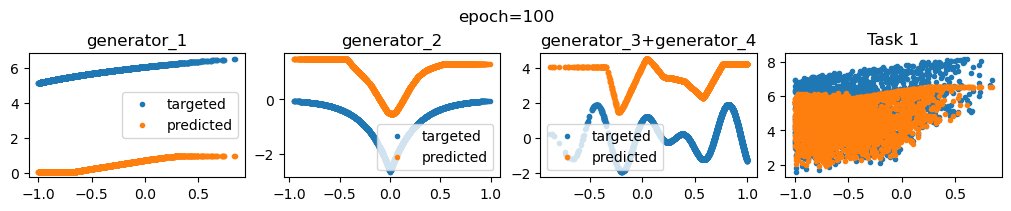

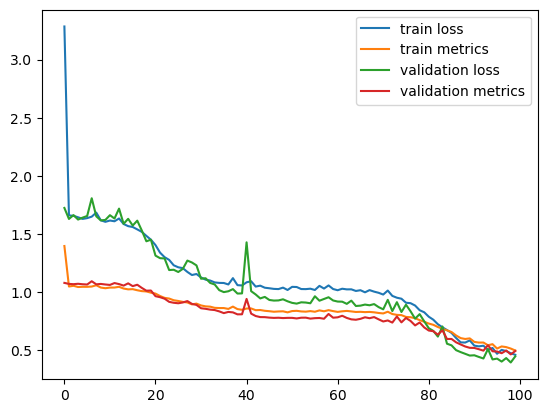

In [14]:
losses_train, metricses_train, losses_val, metricses_val = trainer_relu.train()

In [17]:
cfg.activation = 'exu'
nam_exu = NAM(
    config=cfg, 
    name="NAM Model", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(nam_exu)
trainer_exu = Trainer(cfg, nam_exu, toydataset)   

NAM(
  (feature_dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=64)
        (1): Dropout(p=0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0, inplace=False)
      )
    )
  )
)


In [ ]:
losses_train, metricses_train, losses_val, metricses_val = trainer_exu.train()

loss_train_epoch: 1.024325966835022, MAE_train_epoch: 0.8471529122554895
loss_val_epoch: 0.9356632232666016, MAE_val_epoch: 0.7912528336048126
loss_train_epoch: 1.0129696130752563, MAE_train_epoch: 0.8425524559887972
loss_val_epoch: 0.899654746055603, MAE_val_epoch: 0.7679168879985809
